# Support Vector Machines

In the first half of this exercise, we will be experimenting with SVMs on 2D datasets. Our first example is a 2D example dataset which can be separated by a linear boundary. Let's first load in our dataset and graph it. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn import svm

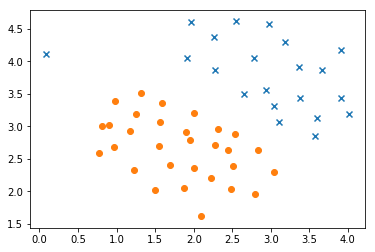

In [2]:
data = loadmat('ex6data1.mat')

allData = pd.DataFrame(data['X'], columns=['x1', 'x2'])
allData['y'] = data['y']

positive = allData[allData['y'] == 1]
negative = allData[allData['y'] == 0]

fig, ax = plt.subplots()
ax.scatter(x=positive['x1'], y=positive['x2'], marker='x')
ax.scatter(x=negative['x1'], y=negative['x2'], marker='o')

One thing to note with our dataset is the outlier located at the upper left. We will find soon enough that based on the value of $C$ we choose to train our SVM with, our decision boundary will choose to include that outlier or not. Now, lets train our SVM. 

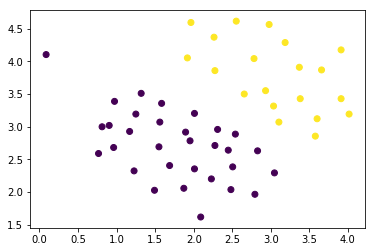

In [3]:
svclassifier = svm.SVC(C=1, kernel='linear')
X = data['X']
y = data['y'].ravel()

svclassifier.fit(X, y)
y_pred = svclassifier.predict(X)

fig, ax = plt.subplots()
ax.scatter(x=allData['x1'], y = allData['x2'], c = y_pred)

Based on our graph, we can see that with a $C$ value of 1, the resulting SVM model does not include the outlier as a positive example. This is because with a lower $C$ value, there is more regularization and therefore higher bias and lower variance.

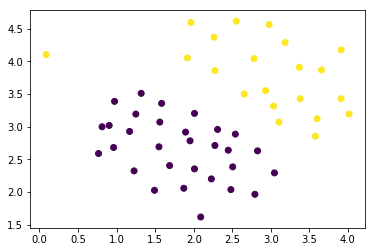

In [4]:
svclassifier = svm.SVC(C=100, kernel='linear')

svclassifier.fit(X, y)
y_pred = svclassifier.predict(X)

fig, ax = plt.subplots()
ax.scatter(x=allData['x1'], y = allData['x2'], c = y_pred)

However, with this graph, the outlier is included as a positive example since the $C$ value is higher and therefore there is less regularization. 

## Non-linear classification

In the next part of this exercise, we will be using SVM with kernels in order to do some non-linear classification. In order to get started on this, first we need a similarity function and in this case we will be using a Gaussian kernel.

In [5]:
# compute the Gaussian kernel between two examples (x(i), x(j))
def gaussianKernel(x1, x2, sigma):
    numerator = np.sum((x1 - x2)**2)
    denominator = 2*(sigma**2)
    return np.exp(-numerator/denominator)

In [6]:
test1 = np.array([1, 2, 1])
test2 = np.array([0, 4, -1])

gaussianKernel(test1, test2, 2)

0.32465246735834974

Using two test examples, we can see that our Gaussian kernel gets the correct value. Using this kernel, we can start classifying non-linear datasets. Lets load the dataset in. 

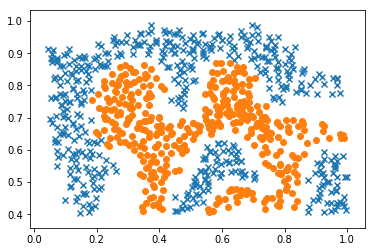

In [7]:
data2 = loadmat('ex6data2.mat')

allData2 = pd.DataFrame(data2['X'], columns=['x1', 'x2'])
allData2['y'] = data2['y']


positive2 = allData2[allData2['y'] == 1]
negative2 = allData2[allData2['y'] == 0]

fig, ax = plt.subplots()
ax.scatter(x=positive2['x1'], y=positive2['x2'], marker='x')
ax.scatter(x=negative2['x1'], y=negative2['x2'], marker='o')

In order to train our SVM, we will be constructing a Gram matrix with our Gaussian kernel function. The Gram matrix is basically the precomputed features that are generated based on the kernel function. There are $m$ rows for each training example and $m$ columns since there are $m$ features. 

In [8]:
def constructGramMatrix(X1, X2, sigma=0.1):
    gramMatrix = np.zeros((X1.shape[0], X2.shape[0]))
    
    for i in range(X1.shape[0]):
        for j in range(X2.shape[0]):
            gramMatrix[i][j] = gaussianKernel(X1[i], X2[j], sigma)
            
    return gramMatrix

In [9]:
X2 = data2['X']
y2 = data2['y'].ravel()
gramMatrix = constructGramMatrix(X2, X2)

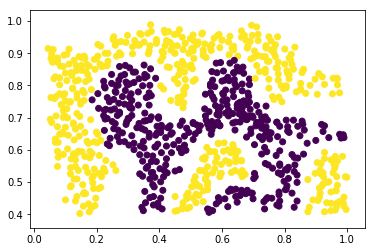

In [10]:
svclassifier = svm.SVC(kernel='precomputed')
svclassifier.fit(gramMatrix, y2)
y_pred2 = svclassifier.predict(gramMatrix)

fig, ax = plt.subplots()
ax.scatter(x=allData2['x1'], y = allData2['x2'], c = y_pred2)

As you can see, our custom kernel using the Gaussian kernel correctly predicts the positive and negative examples. An easier way to do it is to simply use the built-in RBF kernel.

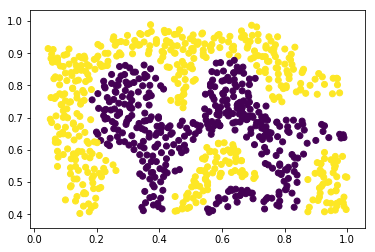

In [11]:
svclassifier = svm.SVC(kernel='rbf', gamma=100)
svclassifier.fit(X2, y2)
y_pred2_rbf = svclassifier.predict(X2)

fig, ax = plt.subplots()
ax.scatter(x=allData2['x1'], y = allData2['x2'], c = y_pred2_rbf)

Using the built-in RBF kernel, we get similar results.

## Choosing the best parameters

In this section we will be using our third dataset with an SVM with Gaussian kernel. Our goal is the use the cross validation set to determine the best $C$ and $\sigma$ parameter to use. Lets first load in the dataset.

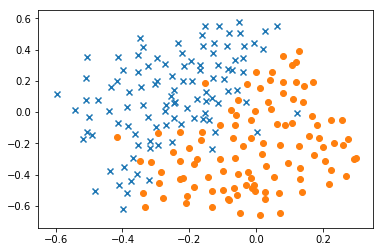

In [12]:
data3 = loadmat('ex6data3.mat')

Xtrain = data3['X']
ytrain = data3['y'].ravel()
Xval = data3['Xval']
yval = data3['yval'].ravel()

allData3 = pd.DataFrame(data3['X'], columns=['x1', 'x2'])
allData3['y'] = data3['y']


positive3 = allData3[allData3['y'] == 1]
negative3 = allData3[allData3['y'] == 0]

fig, ax = plt.subplots()
ax.scatter(x=positive3['x1'], y=positive3['x2'], marker='x')
ax.scatter(x=negative3['x1'], y=negative3['x2'], marker='o')

Next, we are going to test 64 different combinations of $C$ and $\sigma$ and train them on the training set to get the optimized $\theta$ for each model. And then using these 64 models, we will choose the one that has the best score on the validation set.

In [34]:
possibleC = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
possibleSigma = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]


models = []

bestScore = 0
bestParams = {
    'C': 0,
    'sigma': 0
}

for sigma in possibleSigma:
    gramMatrixTrain = constructGramMatrix(Xtrain, Xtrain, sigma)
    gramMatrixVal = constructGramMatrix(Xval, Xtrain, sigma)
    for C in possibleC:
        svclassifier = svm.SVC(kernel='precomputed', C=C)
        svclassifier.fit(gramMatrixTrain, ytrain)
        
        score = svclassifier.score(gramMatrixVal, yval)
        
        if score > bestScore:
            bestScore = score
            bestParams['C'] = C
            bestParams['sigma'] = sigma

In [35]:
bestScore, bestParams

(0.965, {'C': 1, 'sigma': 0.1})